# Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import find_peaks, filtfilt, firwin, fftconvolve, correlate 
from signal_processor import perturbation_L, voice_segmentation, voice_parameters, minmax_np
import time

def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print ("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print ("Toc: start time not set")

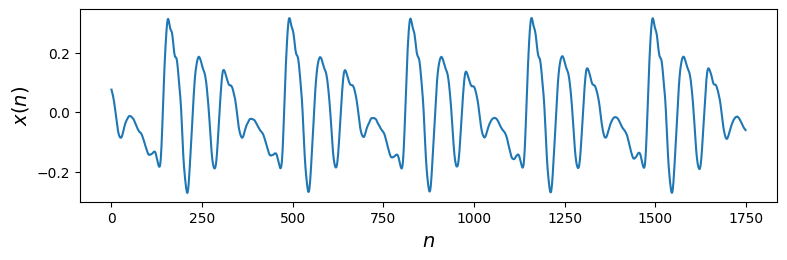

In [2]:
# загрузка аудиофайла
data, fs = sf.read('010.wav', dtype='float32')
# data, fs = sf.read('117_a.wav', dtype='float32')

fig, ax = plt.subplots(figsize=(9,2.5),dpi=100) # figsize=(7,5) 
plt.rcParams.update({'font.size': 14})

ax.plot(data[:1750])
ax.set_xlabel("$ n $",fontsize=14);
ax.set_ylabel("$ x(n) $",fontsize=14);
# plt.legend()

# image_name = f'speech_example.jpg'
# fig.savefig(image_name, format='jpg', dpi=200, bbox_inches='tight', pad_inches = 0.2) 

## voice_parameters_fast

In [3]:
def voice_parameters_fast(data, segments):

    print("RecordingAnalyze voice_parameters: Start processing")

    periods = np.array(segments[1:]) - np.array(segments[:-1])
    amplitudes = np.zeros(len(periods), dtype=np.float64)
    print(amplitudes.shape)
    
    for i in range(len(segments)-1):
        start_idx = segments[i]
        end_idx = segments[i+1]

        # Нахождение минимального и максимального значения амплитуды в периоде
        min_amplitude,max_amplitude = minmax_np(data[start_idx:end_idx])

        # Вычисление амплитуды в периоде
        amplitudes[i] = max_amplitude - min_amplitude          
        

    J1 = perturbation_L(periods, 1)    
    
    J3 = perturbation_L(periods, 3)
    
    J5 = perturbation_L(periods, 5)

    S1 = perturbation_L(amplitudes, 1)
    
    S3 = perturbation_L(amplitudes, 3)
    
    S5 = perturbation_L(amplitudes, 5)
    
    S11 = perturbation_L(amplitudes, 11)    

    print("RecordingAnalyze voice_parameters: Finish processing")
    return J1, J3, J5, S1, S3, S5, S11

## AFC comparison

Text(0.5, 0, 'Отсчеты, n')

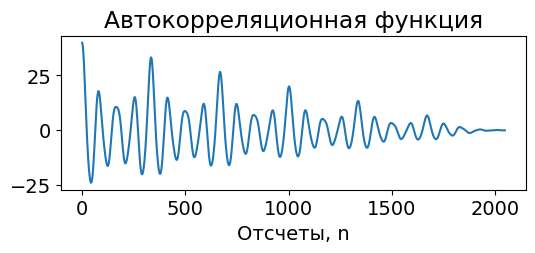

In [19]:
N = 2048
x = data[:2*N] 

# Autocorrelation: time-domain calculation (slow)
lags = np.array(range(0, N))
r_xx = np.zeros_like(lags).astype(float)
for lag in lags:
    tmp_sum = 0
    for n in range(N):
        if ((n+lag)<N) and ((n+lag)>=0):
            tmp_sum = tmp_sum + x[n]*x[n+lag]          
    r_xx[lag] = tmp_sum

# Autocorrelation: frequency-domain calculation (fast)
x_ = np.zeros((2*N))
x_[:N] = x
X = np.fft.fft(x_)
r_xx_ = np.real(np.fft.ifft(X*np.conj(X)))
r_xx_ = r_xx_[:N]

peaks, _ = find_peaks(r_xx)

max_peak = peaks[0]
for i in range(1, len(peaks)):
    if r_xx[peaks[i]] > r_xx[max_peak]:
        max_peak = peaks[i]

peaks2, _ = find_peaks(r_xx)

max_peak2 = peaks2[0]
for i in range(1, len(peaks)):
    if r_xx_[peaks2[i]] > r_xx_[max_peak2]:
        max_peak2 = peaks2[i]

fig, ax = plt.subplots(figsize=(6, 2)) 
ax.plot(r_xx)  #  - r_xx_
ax.set_title('Автокорреляционная функция') 
ax.set_xlabel('Отсчеты, n')

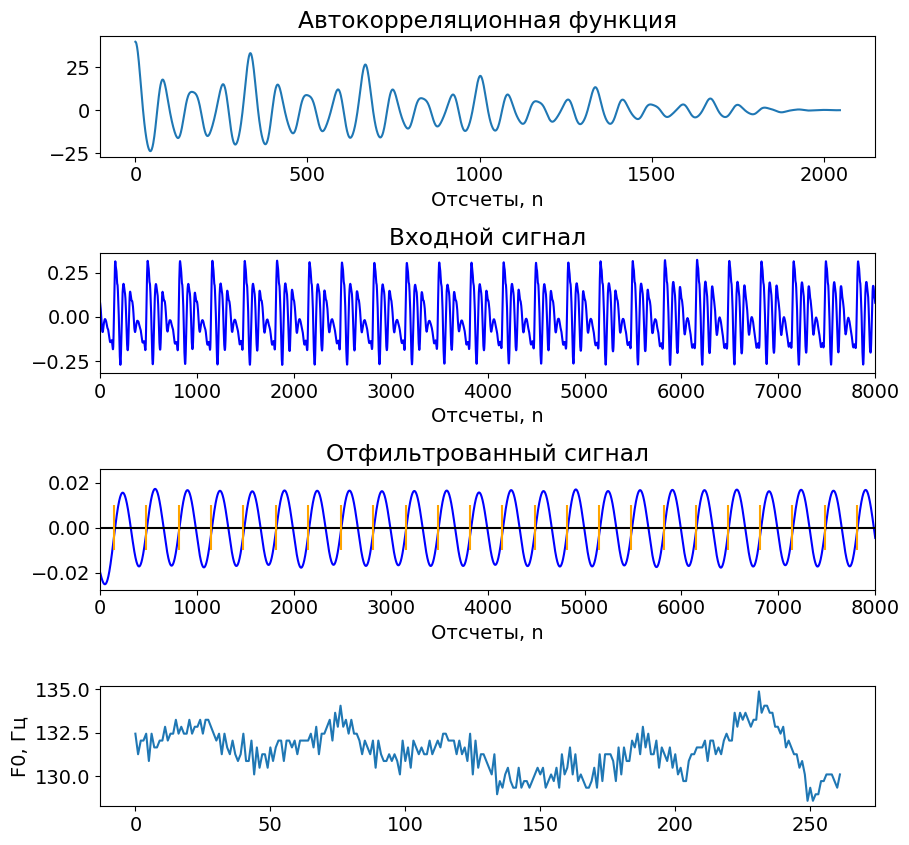

In [7]:
N = 2048
x = data[:N] 

# Autocorrelation: time-domain calculation (slow)
lags = np.array(range(0, N))
# # r_xx = np.zeros_like(lags).astype(float)
# # for lag in lags:
# #     tmp_sum = 0
# #     for n in range(N):
# #         if ((n+lag)<N) and ((n+lag)>=0):
# #             tmp_sum = tmp_sum + x[n]*x[n+lag]          
# #     r_xx[lag] = tmp_sum

# Autocorrelation: frequency-domain calculation (fast)
x_ = np.zeros((2*N))
x_[:N] = x
X = np.fft.fft(x_)
r_xx = np.real(np.fft.ifft(X*np.conj(X)))
r_xx = r_xx[:N]


# # fig, ax = plt.subplots(figsize=(5, 5)) 
# # ax.plot(r_xx) 
# # ax.set_title('Автокорреляционная функция') 
# # ax.set_xlabel('Отсчеты, n')

peaks, _ = find_peaks(r_xx)

max_peak = peaks[0]
for i in range(1, len(peaks)):
    if r_xx[peaks[i]] > r_xx[max_peak]:
        max_peak = peaks[i]

nyq = 0.5*fs    
T0 = max_peak   
T0 = T0/fs      # seconds
F0 = 1.0/(T0)   
cutoff = 1.3*F0/nyq 
N_filter = 601  

taps = firwin(N_filter, cutoff, fs=fs, window=('chebwin',120))

filtered_signal = fftconvolve(data, taps, mode='full')  
filtered_signal = filtered_signal[(N_filter-1)//2:]

# zero_crossings = np.where(np.diff(np.sign(filtered_signal[:len(data)])))[0]

# positive_zero_crossings_left = []

# for i in zero_crossings:    
#     if (filtered_signal[i]<0) and (filtered_signal[i+1]>0):        
#         positive_zero_crossings_left.append(i)

segments = voice_segmentation(data,fs)

periods = np.diff(segments)

fig, axs = plt.subplots(nrows=4, figsize=(10, 10)) 
axs[0].plot(lags, r_xx)
# axs[0].plot(r_xx)
axs[0].set_title('Автокорреляционная функция') 
axs[0].set_xlabel('Отсчеты, n')

axs[1].plot(data[:len(data)], color='blue', label='input')
axs[1].set_xlabel('Отсчеты, n')
axs[1].set_title('Входной сигнал')
# axs[1].axhline(y=0, color='black', linestyle='-')
axs[1].set_xlim(0,8000)

axs[2].plot(filtered_signal[:len(data)], '-', color='blue', label='output')
axs[2].axhline(y=0, color='black', linestyle='-')
axs[2].vlines(segments, -0.01, 0.01, color='orange', linestyle='-', label='positive zero crossings')
axs[2].set_xlabel('Отсчеты, n')
axs[2].set_title('Отфильтрованный сигнал')
axs[2].set_xlim(0,8000)

F0 = fs/periods

axs[3].plot(F0)
axs[3].set_ylabel('F0, Гц')

plt.subplots_adjust(hspace=0.8, wspace=0.0)
# plt.legend()
plt.show()

In [8]:
periods = []
amplitudes = []

for i in range(len(segments)-1):
    start_idx = segments[i]
    end_idx = segments[i+1]
    period = end_idx - start_idx
    periods.append(period)

    # Нахождение минимального и максимального значения амплитуды в периоде
    min_amplitude = np.min(data[start_idx:end_idx])
    max_amplitude = np.max(data[start_idx:end_idx])

    # Вычисление амплитуды в периоде
    amplitude = max_amplitude - min_amplitude
    amplitudes.append(amplitude)

J1 = perturbation_L(np.array(periods), 1)
S1 = perturbation_L(np.array(amplitudes), 1)

J3 = perturbation_L(np.array(periods), 3)
S3 = perturbation_L(np.array(amplitudes), 3)

J5 = perturbation_L(np.array(periods), 5)
S11 = perturbation_L(np.array(amplitudes), 11)

print(f'J1 = {J1:2.2f}')
print(f'S1 = {S1:2.2f}')

print(f'J3 = {J3:2.2f}')
print(f'S3 = {S3:2.2f}')


print(f'J5 = {J5:2.2f}')
print(f'S11 = {S11:2.2f}')

J1 = 0.52
S1 = 0.77
J3 = 0.32
S3 = 0.39
J5 = 0.28
S11 = 0.72


# Time performance

In [5]:
data, fs = sf.read('010.wav', dtype='float32')

segments = voice_segmentation(data,fs)

tic()
J1, J3, J5, S1, S3, S5, S11 = voice_parameters(data, segments)
toc()

tic()
J1, J3, J5, S1, S3, S5, S11 = segments_fast = voice_parameters_fast(data, segments)
toc()

print(f'J1 = {J1:2.2f}')
print(f'J3 = {J3:2.2f}')
print(f'J5 = {J5:2.2f}')

print(f'S1 = {S1:2.2f}')
print(f'S3 = {S3:2.2f}')
print(f'S5 = {S5:2.2f}')
print(f'S11 = {S11:2.2f}')

RecordingAnalyze voice_segmentation: Started processing
RecordingAnalyze voice_segmentation: Computed r_xx
RecordingAnalyze voice_segmentation: Found peaks
RecordingAnalyze voice_segmentation: Found max peaks
RecordingAnalyze voice_segmentation: Filtered signal
RecordingAnalyze voice_segmentation: Processed segments
RecordingAnalyze voice_parameters: Start processing
RecordingAnalyze voice_parameters: Finish processing
Elapsed time is 0.02802562713623047 seconds.
J1 = 0.52
J3 = 0.32
J5 = 0.28
S1 = 0.77
S3 = 0.39
S5 = 0.46
S11 = 0.72


In [28]:
import timeit
# https://stackoverflow.com/questions/12200580/numpy-function-for-simultaneous-max-and-min/12200671#12200671

size = 1000000
repeat = 10000

print (timeit.timeit(
    'min_,max_ = signal_processor.minmax_np(a)',
    setup='import numpy as np; import signal_processor; a = np.arange(%d, dtype=np.float32)' % size,
    number=repeat), '# numpy minmax')

print (timeit.timeit(
    'min_,max_ = signal_processor.minmax(a)',
    setup='import numpy as np; import signal_processor; a = np.arange(%d, dtype=np.float32)' % size,
    number=repeat), " # nubma min/max")    


6.041063415000281 # numpy minmax
13.772237672999836  # nubma min/max
